The goal here is to fix the misclassification error in the time series using our guess of the confusion matrix. We will try this on June alcohol related tweets.

In [6]:
source('c:/users/tom/pycharmprojects/nyu-research/ts.R')

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [8]:
setwd('c:/users/tom/pycharmprojects/nyu-research/')

Time series output from the prediction on june:

In [44]:
june_simp <- read.csv('C:/Users/Tom/Documents/nyu-test/alc-run/june/summary/summary/alc.csv')

Note that the prediction is around 5% alcohol related, which is pretty high.

In [68]:
head(june_simp)

day,hour,sum,len
1,0,362,6004
1,1,227,3852
1,2,138,2415
1,3,81,1762
1,4,79,1648
1,5,101,2091


Seperate into alcohol and nonalcohol prediction

In [46]:
june_alc <- june_simp$sum
june_tot <- june_simp$len
june_notalc <- june_tot - june_alc

In [10]:
june <- preprocessing('twitter_tsa/data/june/june_alc.csv', 'twitter_tsa/data/june/june_total.csv')
june_alc <- ts(june$series[33:(672+32)], frequency=24)
june_tot <- ts(june$total[33:(672+32)], frequency=24)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


In [47]:
june_notalc <- june_tot - june_alc

A preliminary plot, black is total tweets per hour, red is predicted alcohol. 

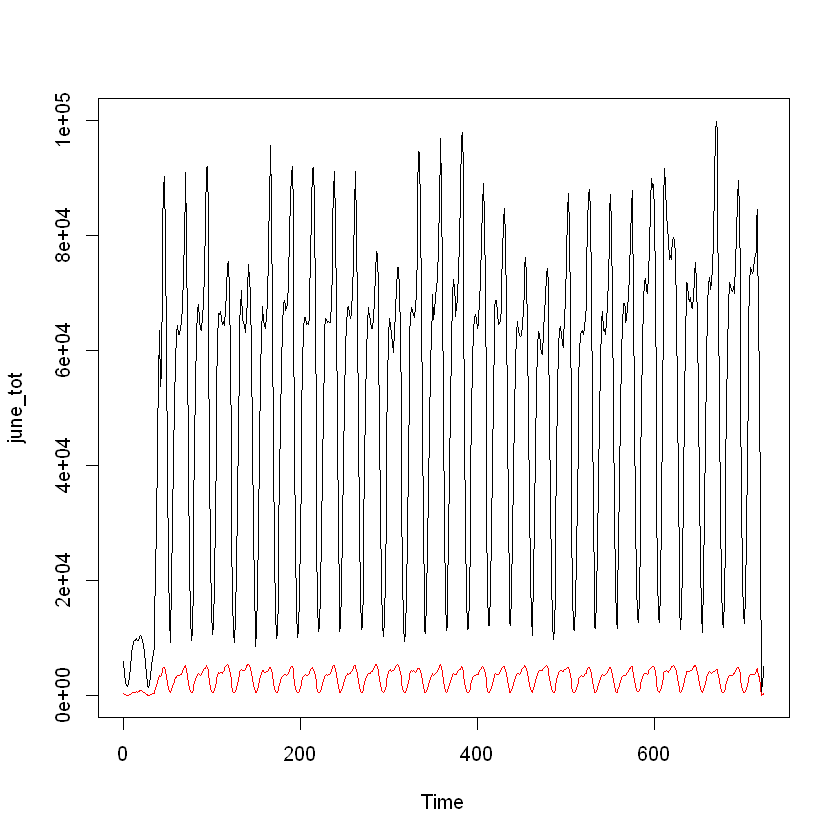

In [48]:
plot.ts(june_tot)
lines(june_alc, col='red')

This is a confusion matrix generated from cross validation and then a test on a large set of presumed non-alcohol related tweets.

In [53]:
m_conf <- matrix(c(95351/100000, 4649/100000, 1430/10295, 8865/10295), nrow=2, ncol=2, byrow=TRUE)

In [54]:
rowSums(m_conf)

[1] 1 1

In [55]:
m_conf

0.9535100,0.0464900
0.1389024,0.8610976


We can write a vector equation as follows: let M = [[m00, m01, m10, m11]] be the confusion matrix, t0 = true negatives, t1 = true positives (alchol related), p0 = predicted negative, p1 = predicted positive. Hence:

[t0, t1] * M = [p0, p1]

=>

[t0, t1] = [p0, p1] * inv(M)

When we have time series, we can replace [t0, t1] and [p0, p1] by nx2 matrices representing time series, n is the number of hours, 2 is the number of classes.
We implement this to get a better guess at the true distributions.

Predicted (predict_neg, predict_pos) time series matrix.

In [56]:
v_predictions <- cbind(as.vector(june_notalc), as.vector(june_alc))

In [67]:
head(v_predictions)

5642,362
3625,227
2277,138
1681,81
1569,79
1990,101


Our "fixed" time series gives between 1-2% of tweets as alcohol related:

In [59]:
true_ts <- v_predictions%*%solve(m_conf)

In [71]:
true_ts[40:50,]

54317.10,511.9026
62709.24,792.7645
52731.59,978.4123
55080.50,1088.5034
72452.24,1130.7608
80178.15,1247.8465
87084.03,1061.9744
89348.24,896.7630
78135.66,841.3367
59516.24,580.7587
38939.84,284.1567


A plot of predicted alcohol (black) vs an estimated true alcohol time series (red).

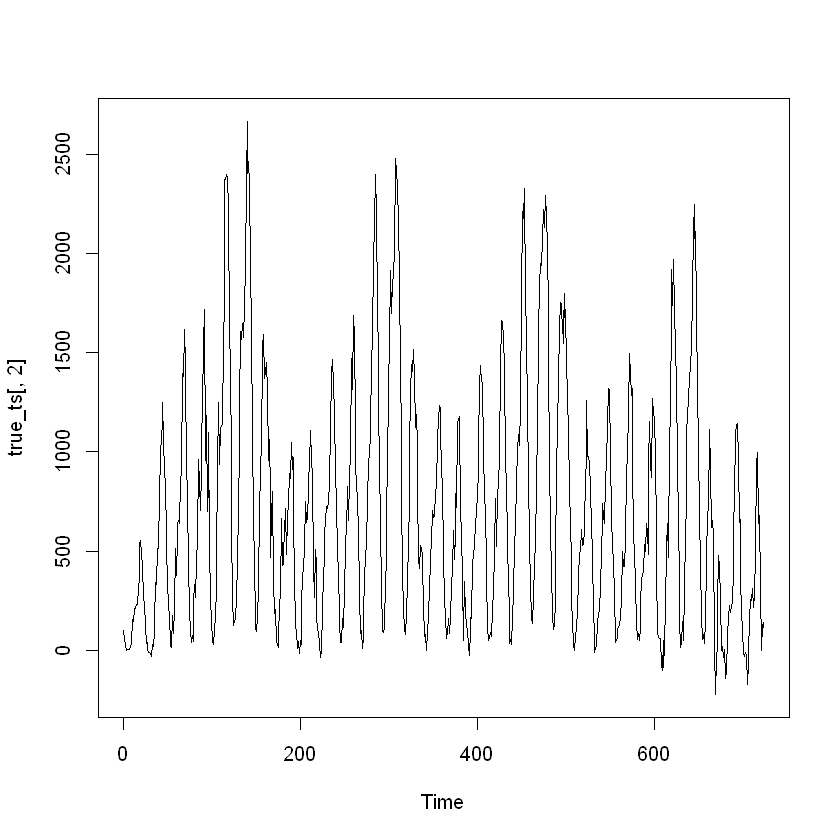

In [72]:
plot.ts(true_ts[,2])

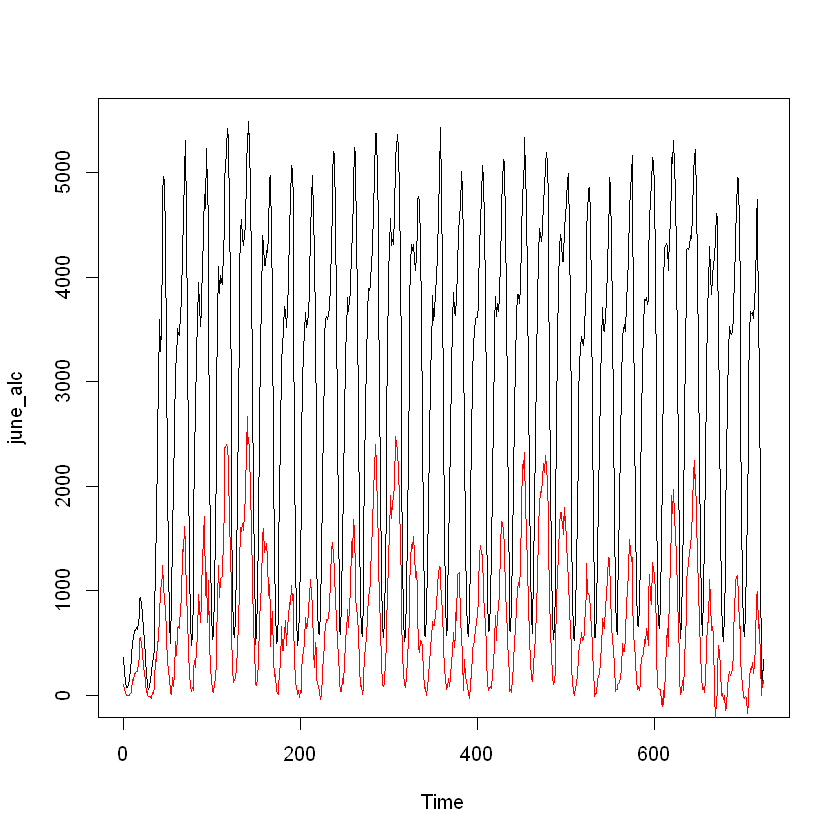

In [64]:
plot.ts(june_alc)
lines(true_ts[,2], col='red')

This looks a lot better, but one obvious problem is that some parts of the new series are slightly negative, which boils down to that the classifier makes fewer false positive predictions than suggested. However, with further fine tuning this approach looks promising! We can also validate this by using a different alcohol classfier like SVM and using the same approach.